In [33]:
#Run a function file that has functions for importing sql data, simple filters, and visual dots
%run PVModel_Functions.py

In [32]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import datatools
import datetime
import pvlib
import math
import statistics

from sklearn.metrics import mean_squared_error
from math import sqrt

#Set plotting format
%matplotlib inline 
mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
mpl.rcParams['axes.titlesize']=22
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style('whitegrid')
sns.set_context("poster", font_scale=1)

In [34]:
#Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
mod_info = pd.read_excel('module_coefficients_bhk.xlsx')
mod_info.index = mod_info['Manufacturer']
del mod_info['Manufacturer']
#defines the specific module given the previous user input and module coefficients file
#S1
module = mod_info['Panasonic']
# #S2
# module = mod_info['Can275']
start = module['start']
end = module['end']
m_u = (module['mass'])/((module['length'])*(module['width']))

In [35]:
#read in input file & format timesteps & datetime index
# inputs = pd.read_excel('Blind_Comp.xlsx')

#S1
inputs = pd.read_excel('Blind_Comp.xlsx')

# #S2
# inputs = pd.read_excel('Blind_Comp_Can275.xlsx')

daterng_all = pd.date_range(start='01/01/2020', end='12/31/2020', freq='H')
daterng_all = daterng_all.drop(daterng_all[0])
inputs.index = daterng_all
inputs.index = inputs.index.tz_localize('MST')

#S1
filters = pd.read_csv('filters_8760.csv', index_col=0)

# #S2
# filters = pd.read_csv('filters_8760_S2.csv', index_col=0)

inputs = inputs.merge(filters, on=filters.index)
inputs.index = daterng_all.tz_localize('MST')

inputs = inputs.loc[(inputs['DTU Filter 2'] ==1) & (inputs['DTU Filter 3'] ==1) & (inputs['DTU Filter 4'] ==1) & (inputs['solarGIS_bsrn_pass'] ==1) & (inputs['SNL No Snow'] ==1)]
inputs.drop(['DTU Filter 2', 'DTU Filter 3', 'DTU Filter 4','solarGIS_bsrn_pass', 'SNL No Snow'], axis=1, inplace=True)

# calculate solarposition info (azimuth, zenith, etc)
inputs = inputs.loc[inputs['Measured POA irradiance'] > 100]
inputs = inputs.loc[inputs['Measured DC power'] > 50]

In [36]:
#Calculate Solar Positions & Extraterrestrial DNI
sdf = pvlib.solarposition.get_solarposition(time=inputs.index, latitude=module['latitude'], 
        longitude=module['longitude'],temperature=inputs['Ambient Temp'], altitude=module['altitude'])
inputs['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=inputs.index)
inputs['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=sdf['apparent_zenith'])

aoi = pvlib.irradiance.aoi(surface_tilt = module['tilt'], surface_azimuth=module['surface_azimuth'], 
                           solar_zenith = sdf['apparent_zenith'], solar_azimuth=sdf['azimuth'])
poa_direct = (inputs['DNI'] * np.cos(np.radians(aoi)))
poa_direct[poa_direct < 0] = 0
poa_diffuse = pvlib.irradiance.perez(surface_tilt = module['tilt'], surface_azimuth=module['surface_azimuth'],
    dhi=inputs['DHI'],dni=inputs['DNI'], dni_extra=inputs['dni_extra'], solar_zenith=sdf['apparent_zenith'], 
    solar_azimuth=sdf['azimuth'], airmass=inputs['airmass'], model = 'allsitescomposite1988')
poa_global = (poa_diffuse + poa_direct)

In [45]:
#Generate an empty df to store appended results
tempresults = []

In [38]:
#confirm nmot for module temp

In [56]:
#sapm module temperature model
mod_sapm = pvlib.temperature.sapm_module(poa_global=poa_global, temp_air=inputs['Ambient Temp'], 
        wind_speed=inputs['Wind Speed'], a=module['A'], b=module['B']).to_frame()
mod_sapm.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
mod_sapm['Model'] = 'SAPM'
mod_sapm['Sol Elev'] = sdf['apparent_elevation']
mod_sapm['POA Global'] = poa_global
mod_sapm['Min RTD'] = inputs['Measured min module temperature']
mod_sapm['Max RTD'] = inputs['Measured max module temperature']
mod_sapm['Median RTD'] = inputs['Measured module temperature']
mod_sapm['DGtemp_%'] = 100*((mod_sapm['Modeled Temp']-mod_sapm['Median RTD'])/mod_sapm['Median RTD'])
mod_sapm['DTmod_°C'] = (mod_sapm['Modeled Temp']-mod_sapm['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
mod_sapm['Time'] = mod_sapm.index
tempresults.append(mod_sapm)

#faiman module temperature model
temp_faiman = pvlib.temperature.faiman(poa_global=poa_global, temp_air=inputs['Ambient Temp'], 
                wind_speed=inputs['Wind Speed'], u0=module['U0'], u1=module['U1']).to_frame()
temp_faiman.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
temp_faiman['Model']='Faiman'
temp_faiman['Sol Elev'] = sdf['apparent_elevation']
temp_faiman['POA Global'] = poa_global
temp_faiman['Min RTD'] = inputs['Measured min module temperature']
temp_faiman['Max RTD'] = inputs['Measured max module temperature']
temp_faiman['Median RTD'] = inputs['Measured module temperature']
temp_faiman['DGtemp_%'] = 100*((temp_faiman['Modeled Temp']-temp_faiman['Median RTD'])/temp_faiman['Median RTD'])
temp_faiman['DTmod_°C'] = (temp_faiman['Modeled Temp']-temp_faiman['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
temp_faiman['Time'] = temp_faiman.index
tempresults.append(temp_faiman)

#ross cell
ross_cell_cell = pvlib.temperature.ross(poa_global=poa_global, temp_air=inputs['Ambient Temp'],
                                           noct=module['nmot'])
ross_cell = ((ross_cell_cell) - ((poa_global/1000)*3)).to_frame()
ross_cell.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
ross_cell['Model']='Ross'
ross_cell['Sol Elev'] = sdf['apparent_elevation']
ross_cell['POA Global'] = poa_global
ross_cell['Min RTD'] = inputs['Measured min module temperature']
ross_cell['Max RTD'] = inputs['Measured max module temperature']
ross_cell['Median RTD'] = inputs['Measured module temperature']
ross_cell['DGtemp_%'] = 100*((ross_cell['Modeled Temp']-ross_cell['Median RTD'])/ross_cell['Median RTD'])
ross_cell['DTmod_°C'] = (ross_cell['Modeled Temp']-ross_cell['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
ross_cell['Time'] = ross_cell.index
tempresults.append(ross_cell)

#pvsyst cell
pvsyst_cell_cell = pvlib.temperature.pvsyst_cell(poa_global=poa_global, temp_air=inputs['Ambient Temp'], 
                    wind_speed=inputs['Wind Speed'], eta_m=module['eta'])
pvsyst_cell = ((pvsyst_cell_cell) - ((poa_global/1000)*3)).to_frame()
pvsyst_cell.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
pvsyst_cell['Model']='PVSyst'
pvsyst_cell['Sol Elev'] = sdf['apparent_elevation']
pvsyst_cell['POA Global'] = poa_global
pvsyst_cell['Min RTD'] = inputs['Measured min module temperature']
pvsyst_cell['Max RTD'] = inputs['Measured max module temperature']
pvsyst_cell['Median RTD'] = inputs['Measured module temperature']
pvsyst_cell['DGtemp_%'] = 100*((pvsyst_cell['Modeled Temp']-pvsyst_cell['Median RTD'])/pvsyst_cell['Median RTD'])
pvsyst_cell['DTmod_°C'] = (pvsyst_cell['Modeled Temp']-pvsyst_cell['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
pvsyst_cell['Time'] = pvsyst_cell.index
tempresults.append(pvsyst_cell)

#SAM NOCT cell
sam_cell_cell = pvlib.temperature.noct_sam(poa_global=poa_global, temp_air=inputs['Ambient Temp'], 
            wind_speed=inputs['Wind Speed'],noct = module['nmot'], module_efficiency = module['eta'])
sam_cell = ((sam_cell_cell) - ((poa_global/1000)*3)).to_frame()
sam_cell.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
sam_cell['Model']='SAM NOCT'
sam_cell['Sol Elev'] = sdf['apparent_elevation']
sam_cell['POA Global'] = poa_global
sam_cell['Min RTD'] = inputs['Measured min module temperature']
sam_cell['Max RTD'] = inputs['Measured max module temperature']
sam_cell['Median RTD'] = inputs['Measured module temperature']
sam_cell['DGtemp_%'] = 100*((sam_cell['Modeled Temp']-sam_cell['Median RTD'])/sam_cell['Median RTD'])
sam_cell['DTmod_°C'] = (sam_cell['Modeled Temp']-sam_cell['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
sam_cell['Time'] = sam_cell.index
tempresults.append(sam_cell)

#SAPM Cell
sapm_cell_cell = pvlib.temperature.sapm_cell(poa_global=poa_global, temp_air=inputs['Ambient Temp'], 
            wind_speed=inputs['Wind Speed'], a=module['A'], b=module['B'], deltaT = module['DeltaT'])
sapm_cell = ((sapm_cell_cell) - ((poa_global/1000)*3)).to_frame()
sapm_cell.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
sapm_cell['Model']='SAPM Cell'
sapm_cell['Sol Elev'] = sdf['apparent_elevation']
sapm_cell['POA Global'] = poa_global
sapm_cell['Min RTD'] = inputs['Measured min module temperature']
sapm_cell['Max RTD'] = inputs['Measured max module temperature']
sapm_cell['Median RTD'] = inputs['Measured module temperature']
sapm_cell['DGtemp_%'] = 100*((sapm_cell['Modeled Temp']-sapm_cell['Median RTD'])/sapm_cell['Median RTD'])
sapm_cell['DTmod_°C'] = (sapm_cell['Modeled Temp']-sapm_cell['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
sapm_cell['Time'] = sapm_cell.index
tempresults.append(sapm_cell)

#Fuentes
fuentes_temp_cell = pvlib.temperature.fuentes(poa_global=poa_global, temp_air=inputs['Ambient Temp'], 
                wind_speed=inputs['Wind Speed'],noct_installed=module['nmot'], module_height=2, wind_height=10, 
                surface_tilt=35,module_width=module['width'], module_length=module['length'])
fuentes_temp = ((fuentes_temp_cell) - ((poa_global/1000)*3)).to_frame()
fuentes_temp.rename(columns = {0 : 'Modeled Temp'}, inplace = True)                                
fuentes_temp['Model']='Fuentes'
fuentes_temp['Sol Elev'] = sdf['apparent_elevation']
fuentes_temp['POA Global'] = poa_global
fuentes_temp['Min RTD'] = inputs['Measured min module temperature']
fuentes_temp['Max RTD'] = inputs['Measured max module temperature']
fuentes_temp['Median RTD'] = inputs['Measured module temperature']
fuentes_temp['DGtemp_%'] = 100*((fuentes_temp['Modeled Temp']-fuentes_temp['Median RTD'])/fuentes_temp['Median RTD'])
fuentes_temp['DTmod_°C'] = (fuentes_temp['Modeled Temp']-fuentes_temp['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
fuentes_temp['Time'] = fuentes_temp.index
tempresults.append(fuentes_temp)

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\temperature.py:381: pvlibDeprecationWarning: 
eta_m overwriting module_efficiency
  warn_deprecated(


In [57]:
#Concatenate all of the results from every system with every model
results = pd.concat(tempresults, ignore_index=True)
#results.index = results.TmStamp

In [37]:
results['Model'].unique()

array(['SAPM', 'Faiman', 'Ross', 'PVSyst', 'SAM NOCT', 'SAPM Cell',
       'Fuentes'], dtype=object)

In [53]:
results

,Modeled Temp,Model,Sol Elev,POA Global,Min RTD,Max RTD,Median RTD,DGtemp_%,DTmod_°C,Time
0,10.385881,SAPM,16.646131,518.056551,2.784869,5.641845,5.177106,100.611714,5.208775,2020-01-01 09:00:00-07:00
1,17.666816,SAPM,24.351561,769.024349,14.612876,16.381034,15.212283,16.135208,2.454533,2020-01-01 10:00:00-07:00
2,22.782976,SAPM,29.673420,923.160739,20.982743,23.846076,21.670719,5.132531,1.112256,2020-01-01 11:00:00-07:00
3,28.580119,SAPM,31.930255,988.509478,29.307227,32.371885,30.524462,-6.369789,-1.944344,2020-01-01 12:00:00-07:00
4,28.515876,SAPM,30.763740,916.074541,32.154634,35.043477,33.635832,-15.221731,-5.119956,2020-01-01 13:00:00-07:00
...,...,...,...,...,...,...,...,...,...,...
69018,26.343461,Fuentes,31.773229,996.073734,24.692870,28.414809,25.581024,2.980480,0.762437,2020-12-29 12:00:00-07:00
69019,24.794648,Fuentes,30.548267,975.889055,25.327092,29.369676,26.154208,-5.198249,-1.359561,2020-12-29 13:00:00-07:00
69020,23.633418,Fuentes,26.107823,873.453088,24.199690,28.021827,24.754799,-4.529955,-1.121381,2020-12-29 14:00:00-07:00
69021,21.995763,Fuentes,19.066098,693.989265,21.957716,25.032419,22.591750,-2.638071,-0.595986,2020-12-29 15:00:00-07:00


In [38]:
obs_std = statistics.stdev(results.loc[results['Model']=='SAPM']['Median RTD'])
sapm_std = statistics.stdev(results.loc[results['Model']=='SAPM']['Modeled Temp'])
fai_std = statistics.stdev(results.loc[results['Model']=='Faiman']['Modeled Temp'])
ross_std = statistics.stdev(results.loc[results['Model']=='Ross']['Modeled Temp'])
pvs_std = statistics.stdev(results.loc[results['Model']=='PVSyst']['Modeled Temp'])
sam_std = statistics.stdev(results.loc[results['Model']=='SAM NOCT']['Modeled Temp'])
sapmc_std = statistics.stdev(results.loc[results['Model']=='SAPM Cell']['Modeled Temp'])

In [39]:
sapm_r = np.corrcoef(results.loc[results['Model']=='SAPM']['Modeled Temp'],
              results.loc[results['Model']=='SAPM']['Median RTD'])
fai_r = np.corrcoef(results.loc[results['Model']=='Faiman']['Modeled Temp'],
              results.loc[results['Model']=='SAPM']['Median RTD'])
ross_r = np.corrcoef(results.loc[results['Model']=='Ross']['Modeled Temp'],
              results.loc[results['Model']=='SAPM']['Median RTD'])
pvs_r = np.corrcoef(results.loc[results['Model']=='PVSyst']['Modeled Temp'],
              results.loc[results['Model']=='SAPM']['Median RTD'])
sam_r = np.corrcoef(results.loc[results['Model']=='SAM NOCT']['Modeled Temp'],
              results.loc[results['Model']=='SAPM']['Median RTD'])
sapmc_r = np.corrcoef(results.loc[results['Model']=='SAPM Cell']['Modeled Temp'],
              results.loc[results['Model']=='SAPM']['Median RTD'])

In [45]:
std = [sapm_std, fai_std, ross_std, pvs_std, sam_std, sapmc_std]
corcef = [sapm_r[0][1], fai_r[0][1], ross_r[0][1], pvs_r[0][1], sam_r[0][1], sapmc_r[0][1]]
l = ['SAPM Mod', 'Faiman', 'Ross', 'PVSyst', 'SAM NOCT', 'SAPM Cell']
# Output file name
fname = 'TaylorDiagram_Temp.jpg'

In [46]:
mpl.rcParams['font.size']=10
srl(obs_std, std, corcef, l, fname)

In [10]:
rmse = []
models=['Faiman', 'Fuentes', 'PVSyst', 'Ross', 'SAM NOCT', 'SAPM', 'SAPM Cell']
results = results.dropna()
for model in models:
    rmserror = sqrt(mean_squared_error(results.loc[results['Model']==model]['Median RTD'],
                                        results.loc[results['Model']==model]['Modeled Temp']))
    rmse.append(rmserror)
model_res = pd.DataFrame(rmse, index=models)

In [58]:
grp3 = results.groupby('Model').mean()
grp3['RMSE'] = model_res[0]
grp3['Model'] = grp3.index

In [48]:
grp2 = results.groupby('Model').mean()
grp2['RMSE'] = model_res[0]
grp2['Model'] = grp2.index

In [41]:
grp = results.groupby('Model').mean()
grp['RMSE'] = model_res[0]
grp['Model'] = grp.index

In [59]:
grp3

,Modeled Temp,Sol Elev,POA Global,Min RTD,Max RTD,Median RTD,DGtemp_%,DTmod_°C,RMSE,Model
Model,,,,,,,,,,
Faiman,34.386324,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,-1.000690,5.316482,Faiman
Fuentes,35.551732,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,0.164718,4.900498,Fuentes
PVSyst,35.602752,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,0.215737,5.978629,PVSyst
Ross,38.676745,38.919347,637.677117,34.587237,36.455111,35.392995,NaN,3.316927,5.069745,Ross
SAM NOCT,33.395426,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,-1.991588,6.911574,SAM NOCT
SAPM,35.886227,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,0.499212,6.624207,SAPM
SAPM Cell,36.364458,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,0.977443,6.624207,SAPM Cell


In [49]:
grp2

,Modeled Temp,Sol Elev,POA Global,Min RTD,Max RTD,Median RTD,DGtemp_%,DTmod_°C,RMSE,Model
Model,,,,,,,,,,
Faiman,34.386324,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,-1.000690,5.316482,Faiman
Fuentes,36.827015,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,1.440001,4.900498,Fuentes
PVSyst,37.037445,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,1.650430,5.978629,PVSyst
Ross,38.256105,38.947149,637.784919,34.605954,36.473659,35.410979,NaN,2.974276,5.069745,Ross
SAM NOCT,33.873657,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,-1.513357,6.911574,SAM NOCT
SAPM,35.886227,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,0.499212,6.624207,SAPM
SAPM Cell,37.799151,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,2.412136,6.624207,SAPM Cell


In [42]:
grp

,Modeled Temp,Sol Elev,POA Global,Min RTD,Max RTD,Median RTD,DGtemp_%,DTmod_°C,RMSE,Model
Model,,,,,,,,,,
Faiman,34.386324,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,-1.000690,5.316482,Faiman
Fuentes,36.827015,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,1.440001,4.900498,Fuentes
PVSyst,35.124521,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,-0.262494,5.978629,PVSyst
Ross,38.256105,38.947149,637.784919,34.605954,36.473659,35.410979,NaN,2.974276,5.069745,Ross
SAM NOCT,33.873657,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,-1.513357,6.911574,SAM NOCT
SAPM,35.886227,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,0.499212,6.624207,SAPM
SAPM Cell,35.886227,38.910101,637.641267,34.581013,36.448942,35.387014,NaN,0.499212,6.624207,SAPM Cell


Text(0.5, 0, 'MBE (°C)')

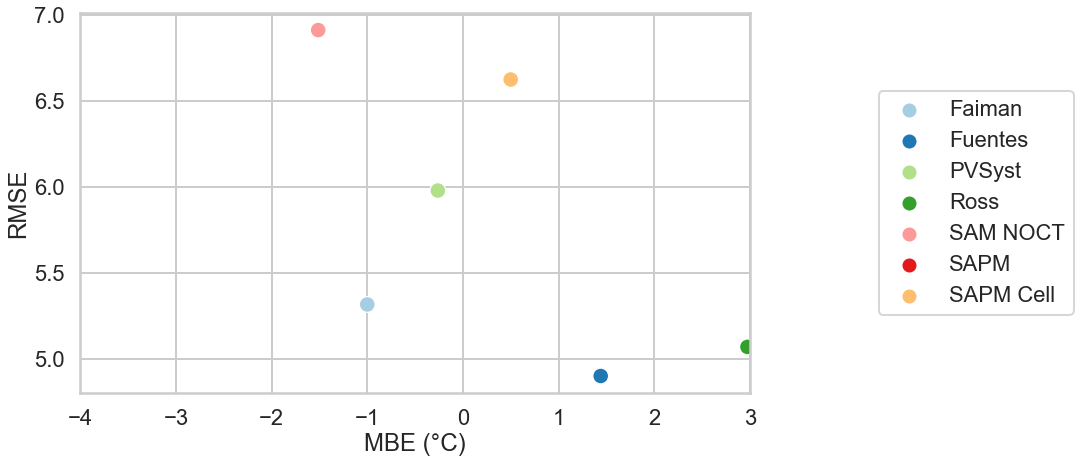

In [43]:
sns.scatterplot(x='DTmod_°C', y='RMSE', data=grp, hue='Model',s=250, palette='Paired')
plt.legend(loc='center right',bbox_to_anchor=(1.5, 0.5))
#plt.ylim(4,9)
plt.xlim(-4,3)
plt.xlabel('MBE (°C)')

Text(0, 0.5, 'Residuals (°C)')

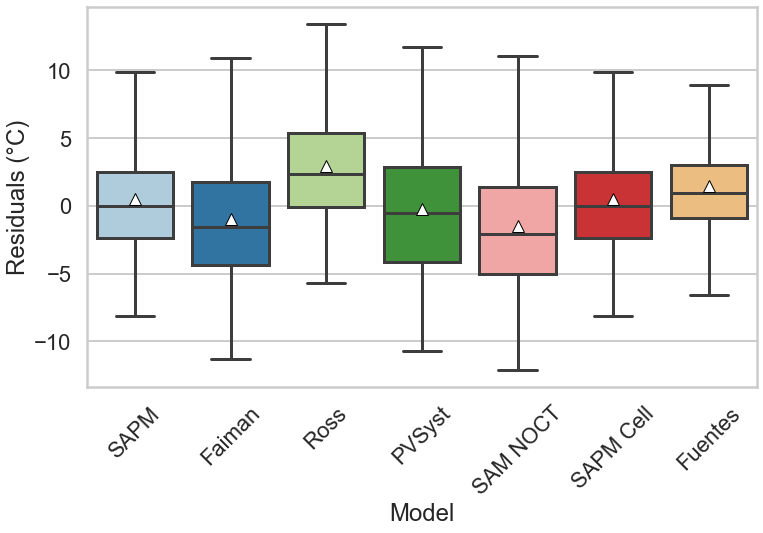

In [44]:
sns.boxplot(data=results, x='Model', y='DTmod_°C', palette='Paired', showmeans=True, showfliers=False,
           meanprops={"markerfacecolor":"white", "markeredgecolor":"black", "markersize":"12"})
plt.xticks(rotation=45)
plt.ylabel('Residuals (°C)')

Text(0.5, 0, 'Residuals (°C)')

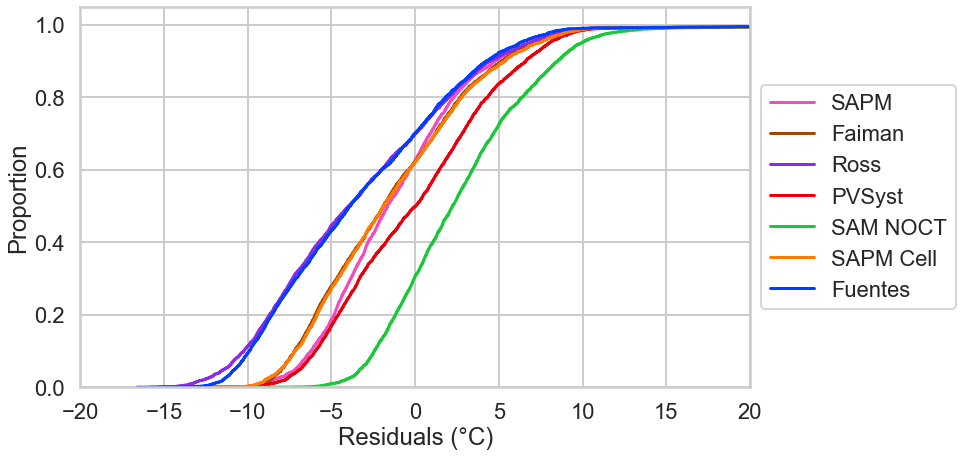

In [15]:
sns.ecdfplot(data=results, x='DTmod_°C', hue='Model', palette='bright')
plt.xlim(-20,20)
plt.ylim(0,1.05)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['SAPM', 'Faiman', 'Ross', 'PVSyst', 'SAM NOCT', 'SAPM Cell', 'Fuentes'] )
plt.xlabel('Residuals (°C)')

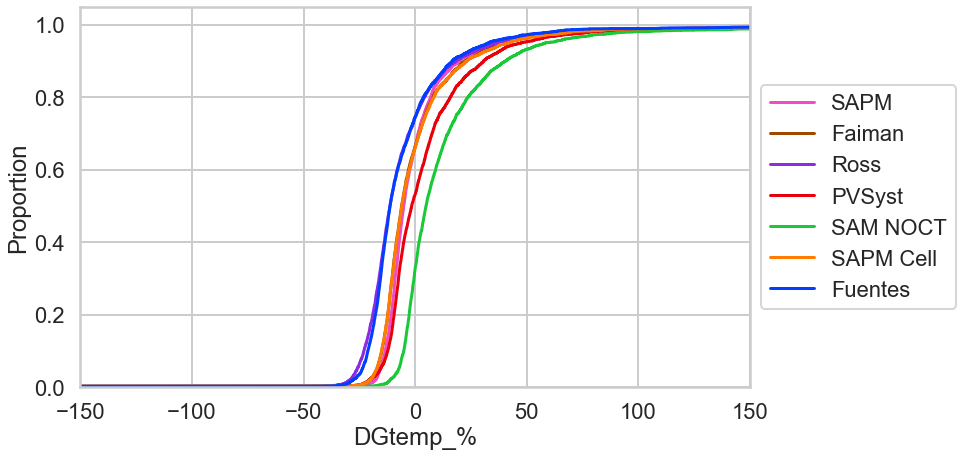

In [100]:
sns.ecdfplot(data=results, x='DGtemp_%', hue='Model', palette='bright')
plt.xlim(-150,150)
plt.ylim(0,1.05)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['SAPM', 'Faiman', 'Ross', 'PVSyst', 'SAM NOCT', 'SAPM Cell', 'Fuentes'] )

In [6]:
#results.to_hdf('results_tempmodelall.h5', key='data', complib='zlib', complevel=9)

In [36]:
results.groupby(['Model']).mean()

,Modeled Temp,Sol Elev,POA Global,Min RTD,Max RTD,Median RTD,DGtemp_%,DTmod_°C
Model,,,,,,,,
Faiman,35.243598,37.692158,610.320649,36.06472,36.931464,36.498092,NaN,-1.254494
Fuentes,35.467588,37.692158,610.320649,36.06472,36.931464,36.498092,NaN,-1.030504
PVSyst,34.806681,37.692158,610.320649,36.06472,36.931464,36.498092,NaN,-1.691411
Ross,37.423904,37.692158,610.320649,36.06472,36.931464,36.498092,NaN,0.925812
SAM NOCT,33.262814,37.692158,610.320649,36.06472,36.931464,36.498092,NaN,-3.235279
SAPM,33.347806,37.692158,610.320649,36.06472,36.931464,36.498092,NaN,-3.150286
SAPM Cell,33.347806,37.692158,610.320649,36.06472,36.931464,36.498092,NaN,-3.150286


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Faiman'),
  Text(1, 0, 'Fuentes'),
  Text(2, 0, 'PVSyst'),
  Text(3, 0, 'Ross'),
  Text(4, 0, 'SAM NOCT'),
  Text(5, 0, 'SAPM'),
  Text(6, 0, 'SAPM Cell')])

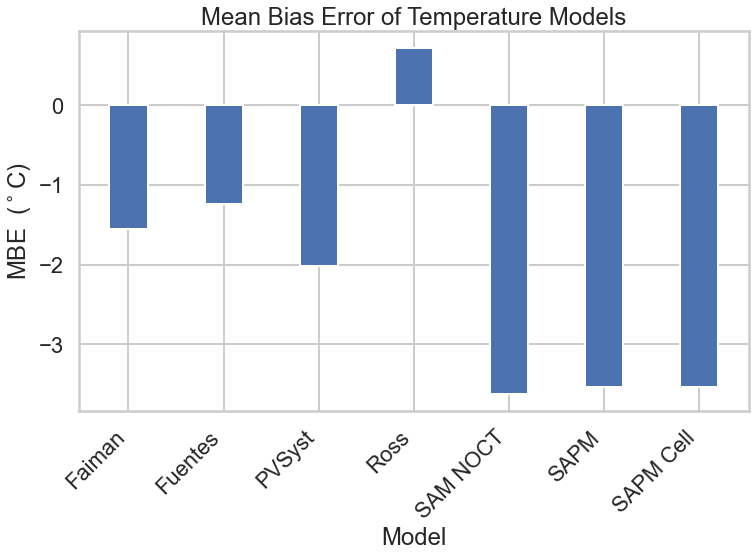

In [13]:
X = results.groupby(['Model']).mean().index
Y= results.groupby(['Model']).mean()['DTmod_°C']
#Z = ngd_comp['GrDfs - DGpoa_W/m2']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis, Y, 0.4)
#plt.bar(X_axis + 0.2, Z, 0.4, label = 'Ground Diffuse Considered')
  
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("MBE  ($^\circ$C)")
plt.title("Mean Bias Error of Temperature Models")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')

## Transient Temperature Model

#### unable to use since the data is at the hourly level and the prilliman model requires it be atleast 20 min intervals

In [60]:
len(inputs['Wind Speed'])

8760

In [52]:
#Generate an empty df to store appended results
ttempresults = []

In [55]:
daterng_all = pd.date_range(start='01/01/2020', end='01/01/2021', freq='H')
daterng_all = daterng_all[~((daterng_all.month == 2) & (daterng_all.day == 29))]
daterng_all = daterng_all.drop(daterng_all[0])
inputs = inputs.reindex(daterng_all)
poa_global = poa_global.reindex(daterng_all)
inputs.index = inputs.index.tz_localize('MST')
poa_global.index = poa_global.index.tz_localize('MST')

In [ ]:
#sapm module temperature model
mod_sapm_ss = pvlib.temperature.sapm_module(poa_global=poa_global, temp_air=inputs['Ambient Temp'], 
        wind_speed=inputs['Wind Speed'], a=module['A'], b=module['B'])
mod_sapm = pvlib.temperature.prilliman(temp_cell=mod_sapm_ss, wind_speed=inputs['Wind Speed'], 
                                       unit_mass = m_u, coefficients=None).to_frame()
mod_sapm.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
mod_sapm['Model'] = 'SAPM'
mod_sapm['Sol Elev'] = sdf['apparent_elevation']
mod_sapm['POA Global'] = poa_global
mod_sapm['Min RTD'] = inputs['Measured min module temperature']
mod_sapm['Max RTD'] = inputs['Measured max module temperature']
mod_sapm['Median RTD'] = inputs['Measured module temperature']
mod_sapm['DGpoa_%'] = 100*((mod_sapm['Modeled Temp']-mod_sapm['Median RTD'])/mod_sapm['Median RTD'])
mod_sapm['DGpoa_C'] = (mod_sapm['Modeled Temp']-mod_sapm['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
mod_sapm['Time'] = mod_sapm.index
ttempresults.append(mod_sapm)

#faiman module temperature model
temp_faiman_ss = pvlib.temperature.faiman(poa_global=poa_global, temp_air=inputs['Ambient Temp'], 
                wind_speed=inputs['Wind Speed'], u0=module['U0'], u1=module['U1'])
temp_faiman = pvlib.temperature.prilliman(temp_cell=temp_faiman_ss, wind_speed=inputs['Wind Speed'], 
                                       unit_mass = m_u, coefficients=None).to_frame()
temp_faiman.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
temp_faiman['Model']='Faiman'
temp_faiman['Sol Elev'] = sdf['apparent_elevation']
temp_faiman['POA Global'] = poa_global
temp_faiman['Min RTD'] = inputs['Measured min module temperature']
temp_faiman['Max RTD'] = inputs['Measured max module temperature']
temp_faiman['Median RTD'] = inputs['Measured module temperature']
temp_faiman['DGpoa_%'] = 100*((temp_faiman['Modeled Temp']-temp_faiman['Median RTD'])/temp_faiman['Median RTD'])
temp_faiman['DGpoa_C'] = (temp_faiman['Modeled Temp']-temp_faiman['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
temp_faiman['Time'] = temp_faiman.index
ttempresults.append(temp_faiman)

#ross cell
ross_cell_ss = pvlib.temperature.ross(poa_global=poa_global, temp_air=inputs['Ambient Temp'],
                                           noct=module['nmot'])
ross_cell = pvlib.temperature.prilliman(temp_cell=ross_cell_ss, wind_speed=inputs['Wind Speed'], 
                                       unit_mass = m_u, coefficients=None).to_frame()
ross_cell.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
ross_cell['Model']='Ross'
ross_cell['Sol Elev'] = sdf['apparent_elevation']
ross_cell['POA Global'] = poa_global
ross_cell['Min RTD'] = inputs['Measured min module temperature']
ross_cell['Max RTD'] = inputs['Measured max module temperature']
ross_cell['Median RTD'] = inputs['Measured module temperature']
ross_cell['DGpoa_%'] = 100*((ross_cell['Modeled Temp']-ross_cell['Median RTD'])/ross_cell['Median RTD'])
ross_cell['DGpoa_C'] = (ross_cell['Modeled Temp']-ross_cell['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
ross_cell['Time'] = ross_cell.index
ttempresults.append(ross_cell)

#pvsyst cell
pvsyst_cell_ss = pvlib.temperature.pvsyst_cell(poa_global=poa_global, temp_air=inputs['Ambient Temp'], 
                    wind_speed=inputs['Wind Speed'])
pvsyst_cell = pvlib.temperature.prilliman(temp_cell=pvsyst_cell_ss, wind_speed=inputs['Wind Speed'], 
                                       unit_mass = m_u, coefficients=None).to_frame()
pvsyst_cell.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
pvsyst_cell['Model']='PVSyst'
pvsyst_cell['Sol Elev'] = sdf['apparent_elevation']
pvsyst_cell['POA Global'] = poa_global
pvsyst_cell['Min RTD'] = inputs['Measured min module temperature']
pvsyst_cell['Max RTD'] = inputs['Measured max module temperature']
pvsyst_cell['Median RTD'] = inputs['Measured module temperature']
pvsyst_cell['DGpoa_%'] = 100*((pvsyst_cell['Modeled Temp']-pvsyst_cell['Median RTD'])/pvsyst_cell['Median RTD'])
pvsyst_cell['DGpoa_C'] = (pvsyst_cell['Modeled Temp']-pvsyst_cell['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
pvsyst_cell['Time'] = pvsyst_cell.index
ttempresults.append(pvsyst_cell)

#SAM NOCT cell
sam_cell_ss = pvlib.temperature.noct_sam(poa_global=poa_global, temp_air=inputs['Ambient Temp'], 
            wind_speed=inputs['Wind Speed'],noct = module['nmot'], module_efficiency = module['eta'])
sam_cell = pvlib.temperature.prilliman(temp_cell=sam_cell_ss, wind_speed=inputs['Wind Speed'], 
                                       unit_mass = m_u, coefficients=None).to_frame()
sam_cell.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
sam_cell['Model']='SAM NOCT'
sam_cell['Sol Elev'] = sdf['apparent_elevation']
sam_cell['POA Global'] = poa_global
sam_cell['Min RTD'] = inputs['Measured min module temperature']
sam_cell['Max RTD'] = inputs['Measured max module temperature']
sam_cell['Median RTD'] = inputs['Measured module temperature']
sam_cell['DGpoa_%'] = 100*((sam_cell['Modeled Temp']-sam_cell['Median RTD'])/sam_cell['Median RTD'])
sam_cell['DGpoa_C'] = (sam_cell['Modeled Temp']-sam_cell['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
sam_cell['Time'] = sam_cell.index
#     sam_cell = sam_cell.loc[~sam_cell.index.duplicated(), :]
#     sam_cell = sam_cell.reindex(daterng_all, method=None)
ttempresults.append(sam_cell)

#SAPM Cell
sapm_cell_ss = pvlib.temperature.sapm_cell(poa_global=poa_global, temp_air=inputs['Ambient Temp'], 
            wind_speed=inputs['Wind Speed'], a=module['A'], b=module['B'], deltaT = module['DeltaT'])
sapm_cell = pvlib.temperature.prilliman(temp_cell=sapm_cell_ss, wind_speed=inputs['Wind Speed'], 
                                       unit_mass = m_u, coefficients=None).to_frame()
sapm_cell.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
sapm_cell['Model']='SAPM Cell'
sapm_cell['Sol Elev'] = sdf['apparent_elevation']
sapm_cell['POA Global'] = poa_global
sapm_cell['Min RTD'] = inputs['Measured min module temperature']
sapm_cell['Max RTD'] = inputs['Measured max module temperature']
sapm_cell['Median RTD'] = inputs['Measured module temperature']
sapm_cell['DGpoa_%'] = 100*((sapm_cell['Modeled Temp']-sapm_cell['Median RTD'])/sapm_cell['Median RTD'])
sapm_cell['DGpoa_C'] = (sapm_cell['Modeled Temp']-sapm_cell['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
sapm_cell['Time'] = sapm_cell.index

ttempresults.append(sapm_cell)

#Fuentes
nainputs = inputs.dropna()
fuentes_temp_ss = pvlib.temperature.fuentes(poa_global=poa_global, temp_air=nainputs['Ambient Temp'], 
                wind_speed=nainputs['Wind Speed'],noct_installed=module['nmot'], module_height=2, wind_height=10, 
                surface_tilt=35,module_width=module['width'], module_length=module['length'])
fuentes_temp_ss = fuentes_temp_ss.reindex(daterng_all, method=None)
fuentes_temp = pvlib.temperature.prilliman(temp_cell=fuentes_temp_ss, wind_speed=inputs['Wind Speed'], 
                                       unit_mass = m_u, coefficients=None).to_frame()
fuentes_temp.rename(columns = {'tmod' : 'Modeled Temp'}, inplace = True)                                
fuentes_temp['Model']='Fuentes'
fuentes_temp['Sol Elev'] = sdf['apparent_elevation']
fuentes_temp['POA Global'] = poa_global
fuentes_temp['Min RTD'] = inputs['Measured min module temperature']
fuentes_temp['Max RTD'] = inputs['Measured max module temperature']
fuentes_temp['Median RTD'] = inputs['Measured module temperature']
fuentes_temp['DGpoa_%'] = 100*((fuentes_temp['Modeled Temp']-fuentes_temp['Median RTD'])/fuentes_temp['Median RTD'])
fuentes_temp['DGpoa_C'] = (fuentes_temp['Modeled Temp']-fuentes_temp['Median RTD'])
#     mod_sapm = mod_sapm.loc[~mod_sapm.index.duplicated(), :]
#     mod_sapm = mod_sapm.reindex(daterng_all, method=None)
fuentes_temp['Time'] = fuentes_temp.index

ttempresults.append(fuentes_temp)

In [ ]:
#Concatenate all of the results from every system with every model
transietn_results = pd.concat(tempresults, ignore_index=True)
#results.index = results.TmStamp

In [33]:
results.groupby(['Model']).mean()

,Modeled Temp,Sol Elev,POA Global,Min RTD,Max RTD,Median RTD,DGpoa_%,DGpoa_C
Model,,,,,,,,
Faiman,33.207390,37.332715,618.747526,32.972971,34.836197,33.791106,NaN,-0.583716
Fuentes,35.541167,37.332715,618.747526,32.972971,34.836197,33.791106,NaN,1.750060
PVSyst,37.599838,37.332715,618.747526,32.972971,34.836197,33.791106,NaN,3.808731
Ross,39.359534,37.332715,618.747526,32.972971,34.836197,33.791106,NaN,5.568428
SAM NOCT,32.710258,37.332715,618.747526,32.972971,34.836197,33.791106,NaN,-1.080849
SAPM,34.655404,37.332715,618.747526,32.972971,34.836197,33.791106,NaN,0.864298
SAPM Cell,36.511647,37.332715,618.747526,32.972971,34.836197,33.791106,NaN,2.720540


In [10]:
results['Difference'] = results['Modeled Temp']-results['Mean RTD']

In [9]:
results.to_hdf('results_tempmodelall.h5', key='data', complib='zlib', complevel=9)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'SAPM'),
  Text(1, 0, 'Faiman'),
  Text(2, 0, 'Ross'),
  Text(3, 0, 'PVSyst'),
  Text(4, 0, 'SAM NOCT'),
  Text(5, 0, 'SAPM Cell'),
  Text(6, 0, 'Fuentes')])

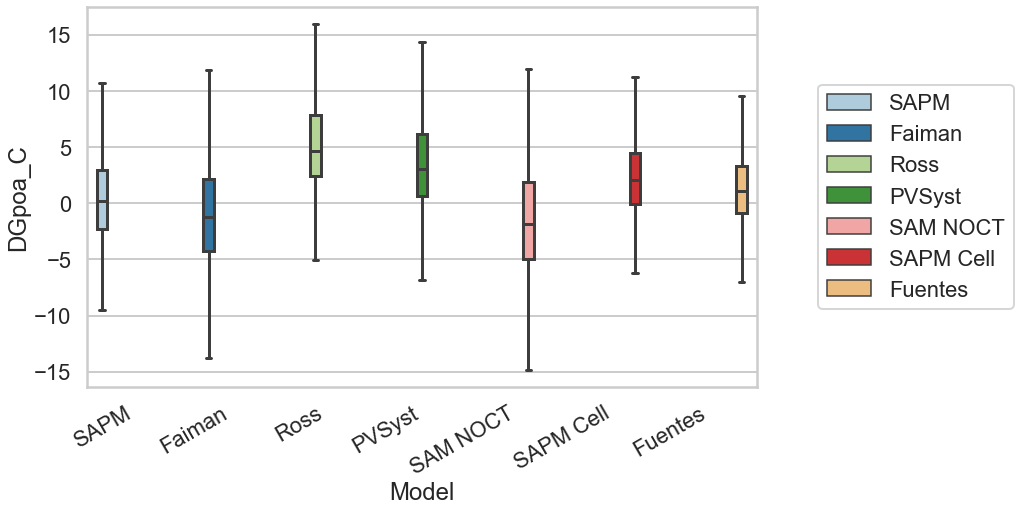

In [36]:
sns.boxplot(x='Model', y='DGpoa_C', hue='Model', data=results, showfliers=False, palette='Paired')
plt.legend(loc='center right',bbox_to_anchor=(1.4, 0.5))
plt.xticks(rotation=30, ha='right')

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa

class TaylorDiagram(object):
    def __init__(self, STD ,fig=None, rect=111, label='_'):
        self.STD = STD
        tr = PolarAxes.PolarTransform()
        # Correlation labels
        rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
        tlocs = np.arccos(rlocs) # Conversion to polar angles
        gl1 = gf.FixedLocator(tlocs) # Positions
        tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        # Standard deviation axis extent
        self.smin = 0
        self.smax = 1.5 * self.STD
        gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
        if fig is None:
            fig = plt.figure()
        ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
        fig.add_subplot(ax)
        # Angle axis
        ax.axis['top'].set_axis_direction('bottom')
        ax.axis['top'].label.set_text("Corr. Coeff")
        ax.axis['top'].toggle(ticklabels=True, label=True)
        ax.axis['top'].major_ticklabels.set_axis_direction('top')
        ax.axis['top'].label.set_axis_direction('top')        
        # X axis
        ax.axis['left'].set_axis_direction('bottom')
        ax.axis['left'].label.set_text("St Dev")
        ax.axis['left'].toggle(ticklabels=True, label=True)
        ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
        ax.axis['left'].label.set_axis_direction('bottom')
        # Y axis
        ax.axis['right'].set_axis_direction('top')
        ax.axis['right'].label.set_text("St Dev")
        ax.axis['right'].toggle(ticklabels=True, label=True)
        ax.axis['right'].major_ticklabels.set_axis_direction('left')
        ax.axis['right'].label.set_axis_direction('top')
        # Useless
        ax.axis['bottom'].set_visible(False)
        # Contours along standard deviations
        ax.grid()
        self._ax = ax # Graphical axes
        self.ax = ax.get_aux_axes(tr) # Polar coordinates
        # Add reference point and STD contour
        l , = self.ax.plot([0], self.STD, 'k*', ls='', ms=8, label=label)
        t = np.linspace(0, (np.pi / 2.0))
        r = np.zeros_like(t) + self.STD
        self.ax.plot(t, r, 'k--', label='_')
        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]
    def add_sample(self,STD,r,*args,**kwargs):
        l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
        self.samplePoints.append(l)
        return l
    def add_contours(self,levels=5,**kwargs):
        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
        RMSE=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
        contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
        return contours

def srl(obsSTD, s, r, l, fname):
    fig=plt.figure()
    dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='Observed')
    plt.clabel(dia.add_contours(colors='0.5'), inline=1, fontsize=10)
    cs = plt.matplotlib.cm.Set1(np.linspace(0, 1, len(l)))
    srlc = zip(s, r, l, cs)
    for i in srlc:
        dia.add_sample(i[0], i[1], label=i[2], c=i[3], marker='s')
    spl = [p.get_label() for p in dia.samplePoints]
    fig.legend(dia.samplePoints, spl, numpoints=1, prop=dict(size='medium'), loc=[0.8, 0.7])
    plt.title('POA Models')
    plt.savefig(fname, dpi=300)
    plt.clf()
    plt.close(fig)